Let's start by importing the necessary libraries.

In [1]:
%pip install PyGithub python-dotenv pandas tqdm cachetools scikit-learn nbformat numpy tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


From the libraries `Github`, `pandas`, `dotenv`, `os` and `sklearn`, we will import the necessary functions to download the dataset, manipulate the data, and train the model.

In [2]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv, path, remove
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from matplotlib import pyplot as plt

<div class="alert alert-block alert-success">
Let's set up the github account and define our main methods.
</div>

In [3]:
load_dotenv(override=True)
g = Github(getenv('GITHUB_TOKEN'), per_page=100)

In [4]:
def get_commit_messages(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    messages = [repo_obj.get_commit(commit).commit.message for commit in commits['id']]
        
    return pd.DataFrame(messages, columns=['message'])

In [5]:
def get_pull_reqs_related_to_commits(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    pull_reqs = repo_obj.get_pulls(state='all')
    
    data = []
    
    for commit in commits['id']:
        for pull_req in pull_reqs:
            if pull_req.merge_commit_sha == commit:
                data.append({
                    'pull_req_id': pull_req.number,
                    'pull_req_title': pull_req.title,
                    'pull_req_body': pull_req.body
                })

    return pd.DataFrame(data, columns=['pull_req_id', 'pull_req_title', 'pull_req_body'])

In [6]:
def get_directories(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    
    def extract_directories(commit_id):
        directories = set()
        for file in repo_obj.get_commit(commit_id).files:
            file_path = file.filename
            directory = '/'.join(file_path.split('/')[:-1]) if '/' in file_path else '.'
            directories.add(directory)
        return ' '.join(directories)
    
    commit_dirs = [extract_directories(commit) for commit in commits['id']]
    
    return pd.DataFrame(commit_dirs, columns=['dirs'])

<div class="alert alert-block alert-success">
Let's extract the data from all the specified repos and save them in a single dataframe cointaing their id, message, directory, opinion and pull_request infos.
</div>

In [7]:
repos = [('spring-guides', 'gs-accessing-data-jpa'), ('Azure-Samples', 'java-native-telemetry'),
        ('aws-samples', 'amazon-ivs-player-web-sample'), 
        ('aws-samples', 'aws-marketplace-serverless-saas-integration')]

classified_commits = pd.DataFrame(columns=['id', 'message', 'dirs', 'pull_req_id', 
                                           'pull_req_title', 'pull_req_body', 'opinion'])

def process_repo_commits(org: str, repo: str):
    repo_data = pd.read_csv(path.join('repos', f'{repo}.csv'))
    repo_obj = g.get_organization(org).get_repo(repo)
    
    messages_df = get_commit_messages(repo_data, repo_obj)
    directories_df = get_directories(repo_data, repo_obj)
    pull_reqs_df = get_pull_reqs_related_to_commits(repo_data, repo_obj)
    
    combined_df = pd.concat([repo_data['id'], repo_data['ecosystem'], repo_data['repo'],
                             messages_df, directories_df, pull_reqs_df, repo_data['opinion']], axis=1)
    return combined_df

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_repo_commits, org, repo) for org, repo in repos]
    for future in tqdm(as_completed(futures), desc="Processing repos", unit='repo', total=len(repos), ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}] {percentage:3.0f}%'):
        repo_info = future.result()
        if not repo_info.empty:
            classified_commits = pd.concat([classified_commits, repo_info], ignore_index=True)

if path.exists('classified_commits.csv'):
    remove('classified_commits.csv')

classified_commits.to_csv('classified_commits.csv', index=False)

Processing repos:   0%|                                                | 0/4 [00:00<?, ?repo/s]   0%

C:\Users\oheit\AppData\Local\Temp\ipykernel_14376\2716845107.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  classified_commits = pd.concat([classified_commits, repo_info], ignore_index=True)
Processing repos: 100%|████████████████████████████████████████| 4/4 [01:49<00:00, 27.25s/repo] 100%


<div class="alert alert-block alert-info">
<b>Message training:</b> We will use the message of the commit as the main feature to train the model.
</div>

In [8]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(classified_commits['message'])

model = MultinomialNB()

model.fit(X, classified_commits['opinion'])

classified_commits['predicted_opinion'] = model.predict(X)

msg_accuracy = round(accuracy_score(classified_commits['opinion'], classified_commits['predicted_opinion']) * 100, 4)

<div class="alert alert-block alert-info">
<b>Directory training:</b> We will use the file directories of the commit as the main feature to train the model.
</div>

In [9]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(classified_commits['dirs'])

model = MultinomialNB()

model.fit(X, classified_commits['opinion'])

classified_commits['predicted_opinion'] = model.predict(X)

dirs_accuracy = round(accuracy_score(classified_commits['opinion'], classified_commits['predicted_opinion']) * 100, 4)

<div class="alert alert-block alert-info">
<b>Split Training:</b> We will use the opinion and dirs of the commit as the target to train the model.<br>
First - The split data will be stratified based on the opinion labels.<br>
Second - The training will be done with 70% of the data and the test with 30%.
</div>

In [10]:
class_counts = classified_commits['opinion'].value_counts()
filtered_classes = class_counts[class_counts >= 2].index
filtered_commits = classified_commits[classified_commits['opinion'].isin(filtered_classes)]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filtered_commits['message'] + ' ' + filtered_commits['dirs'])

y = filtered_commits['opinion']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42,
)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

split_combined_opinion_accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

split_stratified_combined_opinion_accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)

In [13]:
vectorizer = TfidfVectorizer()
X_message = vectorizer.fit_transform(filtered_commits['message'])
# Step 3: Split the data into training and testing sets

encoder = OneHotEncoder()
X_dirs = encoder.fit_transform(filtered_commits[['dirs']])

X_combined = hstack([X_message, X_dirs])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# To predict new messages with dirs
new_message = ["Update syntax for cloud metrics"]
new_dirs = ["src"]

# Transform the new message and dirs
new_message_tfidf = vectorizer.transform(new_message)
new_dirs_encoded = encoder.transform(pd.DataFrame(new_dirs, columns=['dirs']))

# Combine the new message and dirs
new_combined = hstack([new_message_tfidf, new_dirs_encoded])

# Predict the opinion
predicted_opinion = clf.predict(new_combined)
print(f'Predicted opinion: {predicted_opinion[0]}')

Accuracy: 56.67%
Predicted opinion: perfective


<div class="alert alert-block alert-warning">
    <b>Accuracy Visualization:</b> We will use plots to visualize the data and the model's performance.
</div>

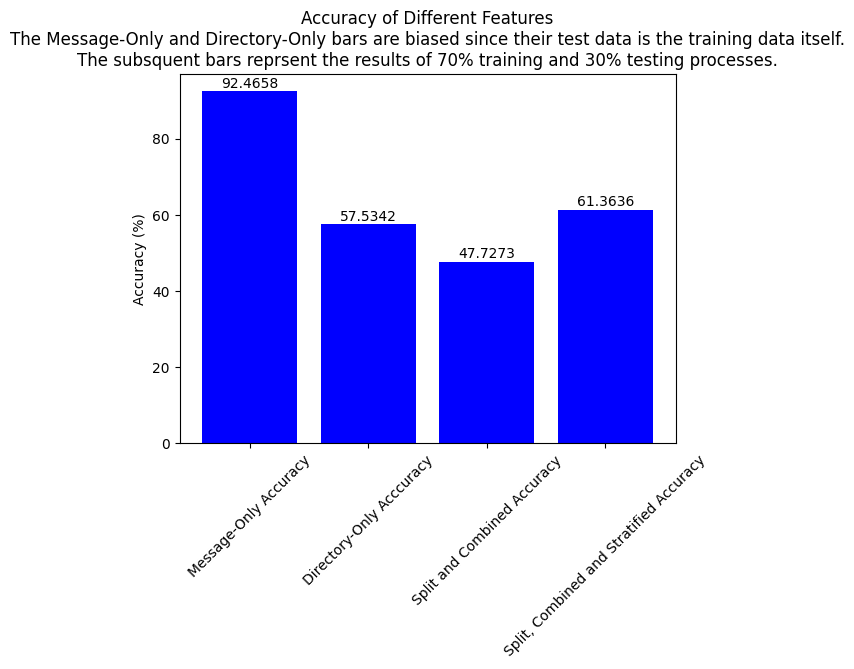

In [14]:
result_df = pd.DataFrame({
    'Training Method': ['Message-Only Accuracy', 'Directory-Only Acccuracy', 'Split and Combined Accuracy', 'Split, Combined and Stratified Accuracy'],
    'Accuracy': [msg_accuracy, dirs_accuracy, split_combined_opinion_accuracy, split_stratified_combined_opinion_accuracy]
})

fig, ax = plt.subplots()
ax.bar(result_df['Training Method'], result_df['Accuracy'], color='blue')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Different Features\nThe Message-Only and Directory-Only bars are biased since their test data is the training data itself.\nThe subsquent bars reprsent the results of 70% training and 30% testing processes.')
plt.xticks(rotation=45)

for i, v in enumerate(result_df['Accuracy']):
    ax.text(i, v + 1, str(v), color='black', ha='center')

fig.savefig('images/accuracy.png', bbox_inches='tight')

<div class="alert alert-block alert-warning">
    <b>Opinions Visualization:</b> We will use plots to visualize the distribution of the opinions.
</div>

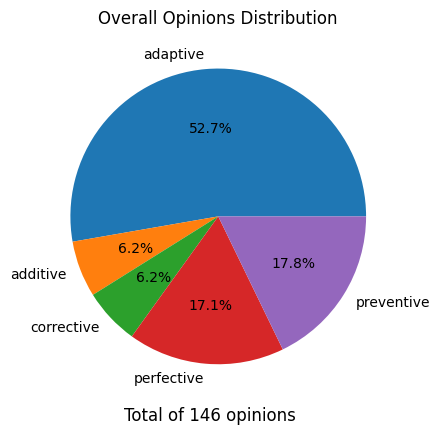

In [15]:
opinions_arr = np.array(classified_commits['opinion'])
opinions_unique, counts = np.unique(opinions_arr, return_counts=True)

overall_opinions_average = pd.DataFrame(list(zip(opinions_unique, counts)),
                                        columns=['type', 'amount'])

fig, ax = plt.subplots()
ax.pie(overall_opinions_average['amount'], labels=overall_opinions_average['type'], autopct='%1.1f%%')
ax.set_title('Overall Opinions Distribution')
fig.suptitle(f'Total of {sum(overall_opinions_average["amount"])} opinions', y=0.10)
fig.savefig('images/overall_opinions.png')

In [16]:
ecosystems = ['Azure-Samples', 'aws-samples', 'spring-guides']

opinions = []

for ecosystem in ecosystems:
    opinions_arr = np.array(classified_commits[classified_commits['ecosystem'] == ecosystem]['opinion'])
    opinions_unique, counts = np.unique(opinions_arr, return_counts=True)

    opinions.append(pd.DataFrame(list(zip(opinions_unique, counts)),
                                 columns=['type', 'amount']))

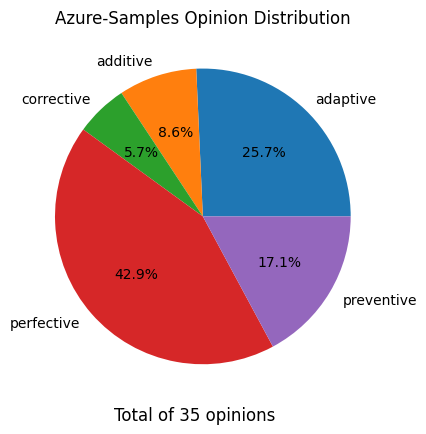

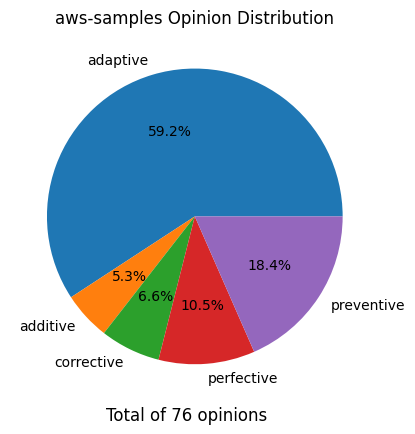

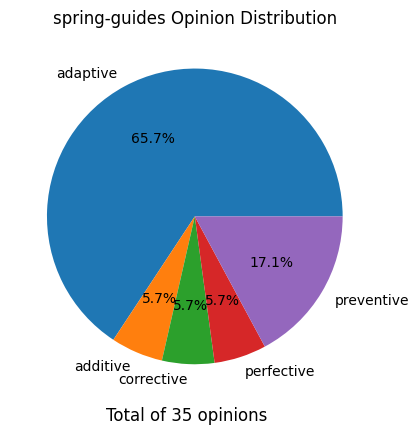

In [17]:
fig, ax = plt.subplots()
ax.pie(opinions[0]['amount'], labels=opinions[0]['type'], autopct='%1.1f%%')
ax.set_title('Azure-Samples Opinion Distribution')
fig.suptitle(f'Total of {sum(opinions[0]["amount"])} opinions', y=0.10)
fig.savefig('images/azure.png')

fig, ax = plt.subplots()
ax.pie(opinions[1]['amount'], labels=opinions[1]['type'], autopct='%1.1f%%')
ax.set_title('aws-samples Opinion Distribution')
fig.suptitle(f'Total of {sum(opinions[1]["amount"])} opinions', y=0.10)
fig.savefig('images/aws-samples.png')

fig, ax = plt.subplots()
ax.pie(opinions[2]['amount'], labels=opinions[2]['type'], autopct='%1.1f%%')
ax.set_title('spring-guides Opinion Distribution')
fig.suptitle(f'Total of {sum(opinions[2]["amount"])} opinions', y=0.10)
fig.savefig('images/spring-guides.png')